<a href="https://colab.research.google.com/github/slp22/data-engineering-project/blob/main/engineering_monkeypox_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Data Engineering | Pipeline

# Monkeypox Tweets

## Imports

In [1]:
import json
import logging
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, itertools
import pandas as pd
import pathlib as Path
import pickle
import PIL
import random
import seaborn as sns
import sklearn as sk
import warnings
import zipfile


import nltk
import re
import en_core_web_sm
import string
pd.set_option('display.max_colwidth', None)
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS


from sqlite3 import connect
import time
from datetime import datetime
from dateutil.parser import parse
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Google Drive

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# https://colab.research.google.com/notebooks/snippets/sheets.ipynb#scrollTo=JiJVCmu3dhFa

# authorize access 
from google.colab import auth
auth.authenticate_user()

# read in from Google Sheets

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


Mounted at /content/drive


### Pyspark



In [3]:
# # https://towardsdatascience.com/pyspark-on-google-colab-101-d31830b238be
# # https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
!tar -xf spark-3.0.0-bin-hadoop3.2.tgz

In [6]:
!pip install -q findspark

In [7]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [8]:
import findspark
findspark.init()

In [9]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, lower
from pyspark.sql.types import StructType,StructField, StringType, IntegerType


## 1 | Pipeline Design


* **Business Problem:** Can we build a dashboard to monitor top trending topics on Twitter about monkeypox?
* **Data source:** [Kaggle Tweets on Monkeypox ](https://www.kaggle.com/datasets/thakurnirmalya/monkeypox2022tweets)
* **Impact Hypothesis:** 

## 2 | Data Ingestion

#### 2.1  [Twitter Dataset on the 2022 MonkeyPox Outbreak](https://www.kaggle.com/datasets/thakurnirmalya/monkeypox2022tweets) 
* Dataset is list of TweetIDs

#### 2.2  [Twitter Hydrating](https://towardsdatascience.com/learn-how-to-easily-hydrate-tweets-a0f393ed340e#:~:text=Hydrating%20Tweets) with [DocNow Hydrator](https://github.com/DocNow/hydrator/releases)
* Processed on local machine
* Saved to Google Sheets

### 2.3  Import [hydrated tweets](https://drive.google.com/drive/folders/1NbddxuSF3v5YuOgjvA1G4WgfPUlKfiul?usp=sharing) from GoogleDrive to Colab

In [13]:
# import one set of tweets for EDA (section 3.1)
w = ['TweetIDs_Part1']
tweets = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())

In [38]:
# # import all tweets (section 3.2)
w = ['TweetIDs_Part1', 'TweetIDs_Part2', 'TweetIDs_Part3', 'TweetIDs_Part4', 'TweetIDs_Part5', 'TweetIDs_Part6']

df_1 = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())
df_2 = pd.DataFrame.from_records(gc.open(w[1]).sheet1.get_all_values())
df_3 = pd.DataFrame.from_records(gc.open(w[2]).sheet1.get_all_values())
df_4 = pd.DataFrame.from_records(gc.open(w[3]).sheet1.get_all_values())
df_5 = pd.DataFrame.from_records(gc.open(w[4]).sheet1.get_all_values())
df_6 = pd.DataFrame.from_records(gc.open(w[5]).sheet1.get_all_values())

## 3 | Exploratory Data Analysis

### 3.1  Explore one set: `tweets` (n = 12,656) 

In [118]:
tweets.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
5817,2022-01-02,JoelPau68848306,@JohannaSzabo1 @postblocksyndro @igfbss @GarethW84521928 @NSWHealth @Dom_Perrottet @BradHazzard Hopefully i catch the monkey pox and covid at the same time ! I’m sooooo scared !,https://twitter.com/JoelPau68848306/status/1527363844259332096,,
5820,2022-01-02,cosborne687,@CandiceBergenMP You are the problem . Did you write this during the monkey pox discovery? You are the problem.,https://twitter.com/cosborne687/status/1527372079254777860,"Nipissing, Ontario",


In [15]:
tweets.columns = tweets.iloc[0]
tweets = tweets.drop(index=tweets.index[0])

In [ ]:
tweets.head(2)

In [ ]:
cols_list = list(tweets.columns)
cols_list

In [18]:
tweets['hashtags']
print('num unique hashtags', tweets['hashtags'].nunique())

528

In [19]:
tweets['possibly_sensitive'][0:2]

1    
2    
Name: possibly_sensitive, dtype: object

In [ ]:
tweets['text']

In [21]:
tweets['tweet_url'][0:2]

1        https://twitter.com/Jyates5/status/1527043704967528453
2    https://twitter.com/LeftistHank/status/1527751952448344065
Name: tweet_url, dtype: object

In [ ]:
tweets['lang'].unique()
print('num unique languages', tweets['lang'].nunique())

In [26]:
tweets['user_created_at']

1        Fri Apr 01 00:29:41 +0000 2011
2        Fri Apr 01 13:14:03 +0000 2022
3        Fri Apr 01 15:12:02 +0000 2011
4        Fri Apr 01 16:27:26 +0000 2011
5        Fri Apr 01 17:41:17 +0000 2016
                      ...              
12652    Wed Sep 30 18:20:38 +0000 2015
12653    Wed Sep 30 19:12:03 +0000 2020
12654    Wed Sep 30 22:42:35 +0000 2020
12655    Wed Sep 30 23:06:12 +0000 2009
12656    Wed Sep 30 23:38:29 +0000 2009
Name: user_created_at, Length: 12137, dtype: object

In [29]:
tweets['user_id']
print('num unique user id', tweets['user_id'].nunique())

1                  275288972
2        1509881738302001155
3                  275573209
4                  275604178
5         715957219972530180
                ...         
12652             3826370843
12653    1311383290688004097
12654    1311436211429543943
12655               78734566
12656               78741475
Name: user_id, Length: 12137, dtype: object

In [ ]:
tweets['user_location']
print('num unique location', tweets['user_location'].nunique())

In [115]:
tweets['user_screen_name']
print('num unique screen names', tweets['user_screen_name'].nunique())

1085

In [32]:
tweets = tweets[['date',
                 'user_screen_name',
                 'text',
                 'tweet_url',
                 'user_location',
                 'hashtags']]
tweets.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
1,2011-04-01,Jyates5,@theofficepirate You bro remember them talking about monkey pox lol,https://twitter.com/Jyates5/status/1527043704967528453,,
2,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751952448344065,"Chicago, IL",


In [35]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1248 entries, 5817 to 1369
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              1248 non-null   object
 1   user_screen_name  1248 non-null   object
 2   text              1248 non-null   object
 3   tweet_url         1248 non-null   object
 4   user_location     1248 non-null   object
 5   hashtags          1248 non-null   object
dtypes: object(6)
memory usage: 68.2+ KB


In [ ]:
tweets.reset_index(drop=True)

In [37]:
tweets.to_csv('/content/drive/MyDrive/tweets_eda_clean.csv')

### 3.2  Clean rest of tweet data: `df` (n = 127,940)

In [ ]:
df_1.head(2)

In [ ]:
df_6.tail(2)

In [40]:
# use first row as col name, and drop first row before concatenating 
dfs = [df_1, df_2, df_3, df_4, df_5, df_6]

for d in dfs: 
  d.columns = d.iloc[0]
  d = d.drop(index=d.index[0],
               axis=0,
               inplace=True)

In [ ]:
df_2.head(3)

In [ ]:
# concatenate dfs
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])
df.tail()

In [ ]:
df.info()

In [112]:
# Int64Index: 229181 entries, 1 to 127940, remove duplicates

duplicateRows = df[df.duplicated()]
duplicateRows

,date,user_screen_name,text,tweet_url,user_location,hashtags


In [113]:
df.drop_duplicates(subset=None, inplace=True)

In [ ]:
df.info()

In [46]:
# filter for tweets in English
print('English entries:', (df[df["lang"] == 'en'].count())['lang'])

English entries: 210812


In [47]:
df = df[(df['lang'] == 'en')]
df['lang'].unique()

array(['en'], dtype=object)

In [ ]:
# convert timestamp to date
df['date'] = pd.to_datetime(df['user_created_at'],
                            format='%a %b %d %H:%M:%S +0000 %Y', 
                            errors='coerce').dt.date
df[['date']][:2]

In [ ]:
# filter for tweets in 2022
df = df[(df['date'] > date(2022,1,1))] 
df.head(2)

In [50]:
# explore location column
print(df['user_location'].value_counts())
print('\n', 'Num unique:', df['user_location'].nunique())

                                  16104
Sullivans Island                   1981
United States                       486
Binance Smart Chain                 226
USA                                 180
                                  ...  
Pretoria and Nelspruit                1
CN85                                  1
Durban, South Africa Pinetown         1
Auburn, ME                            1
Crestview, FL                         1
Name: user_location, Length: 3797, dtype: int64

 Num unique: 3797


In [ ]:
# remove numbers, punctuation, and capital letters from location column
alphanumeric = lambda x: re.sub('\w*\d\w*',' ', str(x))
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
                          
df['user_location'] = df.user_location.map(alphanumeric).map(punc_lower)
df.tail(20)

In [109]:
# remove emojis from location column
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
df['user_location'].head(5)

2              chicago  il
6                         
7    charlie lastra s arms
8    charlie lastra s arms
9                         
Name: user_location, dtype: object

### 3.3  Corpus: `tweets` (n = 28,281)

In [ ]:
df = df[['date',
         'user_screen_name',
         'text',
         'tweet_url',
         'user_location',
         'hashtags']]
df.head(2)

In [ ]:
df.reset_index(drop=True)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28281 entries, 2 to 127921
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              28281 non-null  object
 1   user_screen_name  28281 non-null  object
 2   text              28281 non-null  object
 3   tweet_url         28281 non-null  object
 4   user_location     28281 non-null  object
 5   hashtags          28281 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [121]:
# Save corpus
df.to_pickle('/content/drive/MyDrive/tweets.pkl')
df.to_csv(r'/content/drive/MyDrive/tweets.csv')

In [ ]:
df.info()

# 4 | Storage

### 4.1  Create SQL database: `monkeypox.db`

In [60]:
# https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    # find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # connect to a db file if it exists, else create a new file
    con = sqlite3.connect(db_name)
    cur = con.cursor()

    # create table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)

    # upload df
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""    
    cur.executemany(sql_string, rows_to_upload)
  
    # commit changes and close connection
    con.commit()
    con.close()

In [61]:
#  https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

def sql_query_to_pd(sql_query_string: str, db_name: str ='mpox.db') -> pd.DataFrame:
    
    # connect to sql db
    con = sqlite3.connect(db_name)

    # execute sql query
    cursor = con.execute(sql_query_string)

    # fetch data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # close the connection
    con.close()

    # return as df
    return pd.DataFrame(result_data, columns=cols)

### 4.2  Save tweets to database: `corpus`

In [62]:
# read csv as df
input_df = pd.read_csv('/content/drive/MyDrive/tweets.csv')

# upload df as a SQL table
pd_to_sqlDB(input_df,
            table_name='corpus',
            db_name='monkeypox.db')

### 4.4  Count locations in table: `location`

In [65]:
sql_query_string = """
  SELECT user_location, COUNT(user_location) AS count
  FROM tweets
  GROUP BY user_location
  ORDER BY
    COUNT(user_location) DESC
"""

In [66]:
location_df = sql_query_to_pd(sql_query_string, db_name='monkeypox.db')

In [ ]:
location_df.info()

In [ ]:
location_df.tail(10)

### 4.3  Read tables from database: `corpus_df` and `location_df`

In [ ]:
sql_query_string = """
    SELECT *
    FROM tweets
"""
corpus_df = sql_query_to_pd(sql_query_string, db_name='monkeypox.db')
corpus_df

In [ ]:
corpus_df.info()

In [ ]:
location_df.info()

# 5 | Processing

#### 5.1  Word Count (PySpark)
* groupby, count, agg, 
* google = pyspark word frequency


In [72]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark_df = spark.createDataFrame(corpus_df)
spark_df.printSchema()


In [74]:
df_schema = StructType([StructField("date", IntegerType(), True)])

In [75]:
spark_df = spark_df.withColumn('text', 
                               explode(split(lower(col('text')), '\s')))

In [ ]:
(spark_df.groupBy('text')
  .count()
  .orderBy('count', ascending=False)
  .show(50))

In [ ]:
spark_df.groupBy('text')

In [78]:
spark_df = spark_df.withColumn('user_location', 
                               explode(split(lower(col('user_location')), '\s')))

In [ ]:
(spark_df.groupBy('user_location')
  .count()
  .orderBy('count', ascending=False)
  .show(150))

In [80]:
# https://simplemaps.com/data/world-cities

### 5.2 Topic Modeling

In [ ]:
terms = corpus_df['text']
terms.shape

In [82]:
# custom stop words 
stopwords = nltk.corpus.stopwords.words('english')

custom_words = ['monkey',
             'pox',
             'monkeypox',
             'people',
             'covid',
             'amp',
             '19',
             '2022',
             'another',
             'co', 'https', 'cases', 'case', 'new', 'first', 'via', 'confirmed', 'us',
             'going', 'one', 'know',
             'get', 'like', 'go', 'got', 'time', 'think', 'want',
             'health', 'declares', 'outbreak', 'world', 'public', 'declared', 'news', 'says',
            'total', 'take', 'virus', 'already', 'getting', 'sure',
            'spread', 'disease', 'next', 'would', 'need']
stopwords.extend(custom_words)


In [83]:
tf_vectorizer = TfidfVectorizer(stop_words=stopwords, 
                                min_df=0.01, 
                                max_df=.95)
tf_vectorizer

TfidfVectorizer(max_df=0.95, min_df=0.01,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [84]:
# document-term matrix with TF-IDF
tf_doc_term_mtx = tf_vectorizer.fit_transform(terms)
type(tf_doc_term_mtx)

scipy.sparse.csr.csr_matrix

In [85]:
tf_doc_term_df = pd.DataFrame(tf_doc_term_mtx.toarray(), 
                              columns=tf_vectorizer.get_feature_names_out())
tf_doc_term_df.head(2)

,aids,also,anyone,around,back,biden,cdc,children,cnn,come,...,trump,trying,two,vaccine,vaccines,vax,way,well,years,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# # double check that domain specfic words were omitted 
print('monkey' in tf_vectorizer.get_feature_names_out())
print('pox' in tf_vectorizer.get_feature_names_out())
print('monkeypox' in tf_vectorizer.get_feature_names_out())
print('covid' in tf_vectorizer.get_feature_names_out())

# who and what are mentioned in the corpus? not cdc, trump mentioned 
print('rash' in tf_vectorizer.get_feature_names_out())
print('fever' in tf_vectorizer.get_feature_names_out())
print('cdc:', 'cdc' in tf_vectorizer.get_feature_names_out())
print('cdcgov' in tf_vectorizer.get_feature_names_out())
print('centers for disease control and prevention' in tf_vectorizer.get_feature_names_out())
print('walensky' in tf_vectorizer.get_feature_names_out())
print('biden:', 'biden' in tf_vectorizer.get_feature_names_out())



False
False
False
False
False
False
cdc: True
False
False
False
biden: True


In [87]:
# V     visible variables     doc_term             input (corpus matrix)
# W     weights               doc_topic            feature set
# H     hidden variables      topic_term           coefficients

In [88]:
V = tf_doc_term_mtx
V.shape

(28281, 83)

In [89]:
# W matrix = feature set & weights
nmf = NMF(n_components=3, init=None)
W = nmf.fit_transform(V).round(3)
print(type(W))
W.shape

<class 'numpy.ndarray'>


(28281, 3)

In [ ]:
# H matrix = hidden variables & coefficients 
H = pd.DataFrame(nmf.components_.round(2),
                 index = ['c1', 
                          'c2',
                          'c3'] #,
#                           'c4']#,, 
#                           'c5']
                 ,
                 columns = tf_vectorizer.get_feature_names_out())
print('H.shape:',  H.shape)
H.T.style.background_gradient(cmap='Blues')


In [91]:
# function to display topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [92]:
display_topics(nmf, tf_vectorizer.get_feature_names_out(), 15)


Topic  0
emergency, global, pandemic, spreading, biden, cdc, said, risk, even, well

Topic  1
vaccine, smallpox, vaccines, cdc, shingles, day, well, im, yet, biden

Topic  2
gay, men, sex, cnn, dont, spreading, stop, say, community, aids


### 5.3  Word Cloud

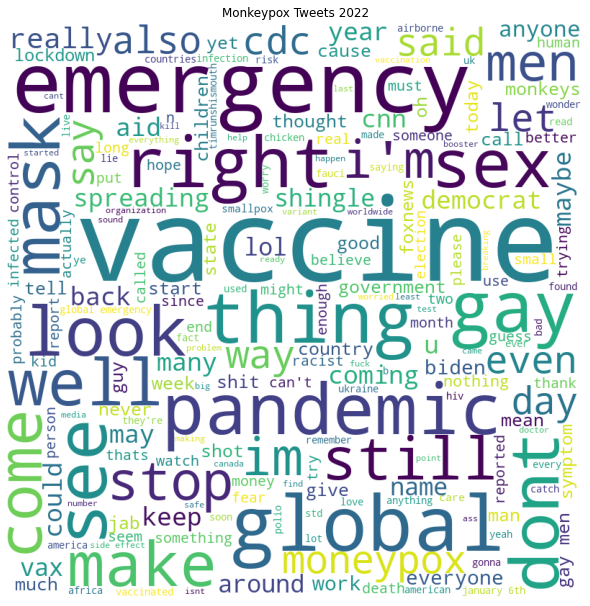

In [93]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

comment_words = ''
stopwords = set(stopwords)
 
for val in terms:
    val = str(val)
    tokens = val.split()     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot WordCloud                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Monkeypox Tweets 2022')
plt.savefig("monkeypox-tweets-word-cloud.jpeg");

### 5.4  Case Counts by State

In [94]:
# import sheet with state lattitude and longitude 
# data source: https://developers.google.com/public-data/docs/canonical/states_csv

# open google spreadsheet
worksheet = gc.open('USA-State-Coordinates').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

states = pd.DataFrame.from_records(rows)

states.columns = states.iloc[0]
states.drop([0], inplace=True)
states.drop(['state'], axis=1, inplace=True)
states.sort_values(by=['name'], inplace=True)
states = states.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'name': 'state'})

states.tail(2)

,lat,lon,state
51,43.78444,-88.787868,Wisconsin
52,43.075968,-107.290284,Wyoming


In [95]:
states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 52
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lat     52 non-null     object
 1   lon     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


In [96]:
# import sheet with US case count by state 
# data source: https://www.cdc.gov/poxvirus/monkeypox/response/2022/us-map.html

worksheet = gc.open('2022-US-mpx-cases-by-state').sheet1
rows = worksheet.get_all_values()
cases = pd.DataFrame.from_records(rows)

cases.columns = cases.iloc[0]
cases.drop([0], inplace=True)
cases.drop(['AsOf', 'Case Range'], axis=1, inplace=True)
cases.sort_values(by=['Location'], inplace=True)

cases.tail(2)

,Location,Cases
51,Wisconsin,56
52,Wyoming,1


In [97]:
# US case count by state (long + lat)
map_data = pd.concat([states, cases], axis=1)
map_data = map_data[['Location', 'Cases', 'lat', 'lon' ]]
map_data = map_data.rename(columns={'Location': 'state', 'Cases':'cases'})

map_data.tail(2)
# map_data.info()

,state,cases,lat,lon
51,Wisconsin,56,43.78444,-88.787868
52,Wyoming,1,43.075968,-107.290284


In [ ]:
map_data = map_data.astype({'cases':'int'})

map_data.sort_values(by=['cases'], ascending=False)
# map_data.sort_values(by=['latitude'], ascending=False)



In [ ]:
map_data.head(2)

In [100]:
map_data.to_csv('map_data.csv')  

### 5.5  Tweets by Location

In [101]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3569 entries, 0 to 3568
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_location  3568 non-null   object
 1   count          3569 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.9+ KB


In [ ]:
location_df.tail(20)

# 6 | Deployment

Streamlit App: https://slp22-data-engineering-project-streamlit-mpx-app-ckpzq2.streamlitapp.com/

# 7 | Testing/Robustness

[Python schedule](https://schedule.readthedocs.io/en/stable/examples.html#run-a-job-every-x-minute)